In [ ]:
from server_chunking.helper.pinecone import db_helper_obj
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
import uuid

@tool
def query_tool(sub_queries: list) -> ToolMessage:
    """This is a query tool"""

    if not isinstance(sub_queries, list):
        raise ValueError("Expected 'sub_queries' to be a list of strings.")

    res = []
    for sub_query in sub_queries:
        sentences = db_helper_obj.split_text_into_sentences(sub_query)
        vector = db_helper_obj.embed_sentences_openai(sentences)
        res.append(db_helper_obj.query_method(vector))
    
    tool_call_id = f"tool_call_{uuid.uuid4()}"
    return ToolMessage(name=query_tool.name, content={"results": res}, tool_call_id=tool_call_id)

print(query_tool.name)
print(query_tool.description)
print(query_tool.args)
print(type(query_tool))

/opt/anaconda3/envs/agent/lib/python3.9/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


query_tool
This is a query tool
{'sub_queries': {'items': {}, 'title': 'Sub Queries', 'type': 'array'}}
<class 'langchain_core.tools.structured.StructuredTool'>


In [2]:
decomposed_queries = {'sub_queries': ['Where is UBC located?', 'When was UBC built?']}

message = query_tool.invoke(decomposed_queries)

In [3]:
message

ToolMessage(content="{'results': [{'similar_sentences': ['Founded in 1908, UBC is British Columbia’s oldest university, initially established to serve as a provincial institution for higher education and research. The Vancouver campus, located on the traditional, ancestral, and unceded territory of the Musqueam people, spans over 400 hectares, featuring breathtaking views of the Pacific Ocean, mountains, and forests. With nearly 70,000 students across its Vancouver and Okanagan campuses, UBC is incredibly diverse, attracting students from over 150 countries.', 'The University of British Columbia (UBC) is one of Canada’s most prestigious research universities and consistently ranks among the top 40 universities globally.']}, {'similar_sentences': ['Founded in 1908, UBC is British Columbia’s oldest university, initially established to serve as a provincial institution for higher education and research. The Vancouver campus, located on the traditional, ancestral, and unceded territory of 

In [4]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from dotenv import load_dotenv
import json

import logging

logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s'
)


_ = load_dotenv()

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

class Agent:
    def __init__(self, model_query, tool):
        graph = StateGraph(AgentState)
        graph.add_node("llm_query", self.call_openai_query)
        graph.add_node("search", self.search) # call it search or rag
        # graph.add_node("llm_filter", self.call_openai_filter)
        graph.add_edge("llm_query", "search")
        # graph.add_edge("search", "llm_filter")
        graph.add_edge("search", END)
        graph.set_entry_point("llm_query")
        self.graph = graph.compile()
        # self.tools = {t.name: t for t in tools}
        # self.model_query = model_query.bind_tools(tools)
        self.model_query = model_query
        # self.model_filter = model_filter
        self.tool = tool

    def call_openai_query(self, state: AgentState):
        logging.debug(f"Entering 'call_openai_query' with state: {state}")
        messages = state['messages']
        # system_query = "Decompose the following query into simpler parts"

        system_query = (
        "Decompose the following query into simpler parts and return the result "
        "as a JSON object with a key 'sub_queries' and a value that is a list of strings. "
        "For example: {\"sub_queries\": [\"Question 1\", \"Question 2\"]}"
        )

        messages = [SystemMessage(content=system_query)] + messages
        message = self.model_query.invoke(messages)
        new_state = {'messages': [message]}
        logging.debug(f"Exiting 'call_openai_query' with new state: {new_state}")
        return new_state
    
    def search(self, state: AgentState):
        logging.debug(f"Entering 'search' with state: {state}")
        ai_message_content = state['messages'][-1].content

        try:
            decomposed_queries = json.loads(ai_message_content)
            logging.debug(f"decomposed_queries: {decomposed_queries}")
        except json.JSONDecodeError:
            print("Error: Failed to parse JSON response.")

        message = self.tool.invoke(decomposed_queries)
        new_state = {'messages': [message]}
        logging.debug(f"Exiting 'search' with new state: {new_state}")
        return new_state
    
    # def call_openai_filter(self, state: AgentState):
    #     query = state['messages'][0].content
    #     system_filter = f"Filter and summarize the following results based on the given query:{query}."

    #     messages = state['messages'][-1]
    #     messages = [SystemMessage(content=system_filter)] + messages
    #     message = self.model_filter.invoke(messages)
    #     return {'messages': [message]}

    # def exists_action(self, state: AgentState):
    #     result = state['messages'][-1]
    #     return len(result.tool_calls) > 0

    # def take_action(self, state: AgentState):
    #     tool_calls = state['messages'][-1].tool_calls
    #     results = []
    #     for t in tool_calls:
    #         print(f"Calling: {t}")
    #         if not t['name'] in self.tools:
    #             print("\n ....bad tool name....")
    #             result = "bad tool name, retry"
    #         else:
    #             result = self.tools[t['name']].invoke(t['args'])
    #         results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
    #     print("To the filter model!")
    #     return {'messages': results}

In [5]:
from langchain_openai import ChatOpenAI
# from server_chunking.helper.agent import Agent
from langchain_core.messages import HumanMessage
# from server_chunking.tool.query_tool import query_tool

class Inference:

    def query_workflow(self, user_query):
        tool = query_tool
        model = ChatOpenAI(model="gpt-4o-mini")  # Updated to GPT-4o-mini
        abot = Agent(model, tool)

        messages = [HumanMessage(content=user_query)]
        result = abot.graph.invoke({"messages": messages})
        return result['messages'][-1].content
    
inference_obj = Inference()

In [6]:
model = ChatOpenAI(model="gpt-4o-mini")  # Updated to GPT-4o-mini
abot = Agent(model, query_tool)

2024-12-02 19:21:45,134 - DEBUG - load_ssl_context verify=True cert=None trust_env=True http2=False
2024-12-02 19:21:45,139 - DEBUG - load_verify_locations cafile='/opt/anaconda3/envs/agent/lib/python3.9/site-packages/certifi/cacert.pem'
2024-12-02 19:21:45,191 - DEBUG - load_ssl_context verify=True cert=None trust_env=True http2=False
2024-12-02 19:21:45,196 - DEBUG - load_verify_locations cafile='/opt/anaconda3/envs/agent/lib/python3.9/site-packages/certifi/cacert.pem'


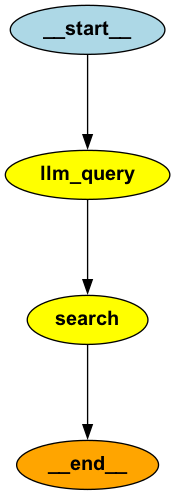

In [7]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [8]:
query = "where is ubc located and when is it built"

res = inference_obj.query_workflow(query)
res

2024-12-02 19:21:45,802 - DEBUG - load_ssl_context verify=True cert=None trust_env=True http2=False
2024-12-02 19:21:45,814 - DEBUG - load_verify_locations cafile='/opt/anaconda3/envs/agent/lib/python3.9/site-packages/certifi/cacert.pem'
2024-12-02 19:21:45,857 - DEBUG - load_ssl_context verify=True cert=None trust_env=True http2=False
2024-12-02 19:21:45,859 - DEBUG - load_verify_locations cafile='/opt/anaconda3/envs/agent/lib/python3.9/site-packages/certifi/cacert.pem'
2024-12-02 19:21:45,891 - DEBUG - Entering 'call_openai_query' with state: {'messages': [HumanMessage(content='where is ubc located and when is it built', additional_kwargs={}, response_metadata={})]}
2024-12-02 19:21:45,905 - DEBUG - Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'content': 'Decompose the following query into simpler parts and return the result as a JSON object with a key \'sub_queries\' and a value that is a list of strings. For example: {"s

"{'results': [{'similar_sentences': ['Founded in 1908, UBC is British Columbia’s oldest university, initially established to serve as a provincial institution for higher education and research. The Vancouver campus, located on the traditional, ancestral, and unceded territory of the Musqueam people, spans over 400 hectares, featuring breathtaking views of the Pacific Ocean, mountains, and forests. With nearly 70,000 students across its Vancouver and Okanagan campuses, UBC is incredibly diverse, attracting students from over 150 countries.', 'The University of British Columbia (UBC) is one of Canada’s most prestigious research universities and consistently ranks among the top 40 universities globally.']}, {'similar_sentences': ['Founded in 1908, UBC is British Columbia’s oldest university, initially established to serve as a provincial institution for higher education and research. The Vancouver campus, located on the traditional, ancestral, and unceded territory of the Musqueam people,